To-do
- Re-perform some analysis after performing error correction (allowing one round to be different)
- Better PCR duplication rate estimation

# Setup

In [91]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [375]:
import collections
import gzip
import itertools
import json
import os
import re
import subprocess
import sys
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Illumina InterOp library
import interop

sys.path.append('../scripts')
import string_distances
import helpers
import plot_features

In [376]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2023-10-09T16:15:17.113954-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

json      : 2.0.9
pandas    : 2.0.2
matplotlib: 3.7.2
seaborn   : 0.12.2
scipy     : 1.11.1
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
interop   : 1.2.4
numpy     : 1.23.5
re        : 2.2.1



In [4]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20231002')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20231002')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231002')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20231002')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [314]:
ROUNDS = ['R1', 'R2', 'R3', 'NYLigOdd']

In [137]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

# Illumina iSeq Run Imaging Metrics

In [5]:
ar = interop.imaging(DIR_DATA)

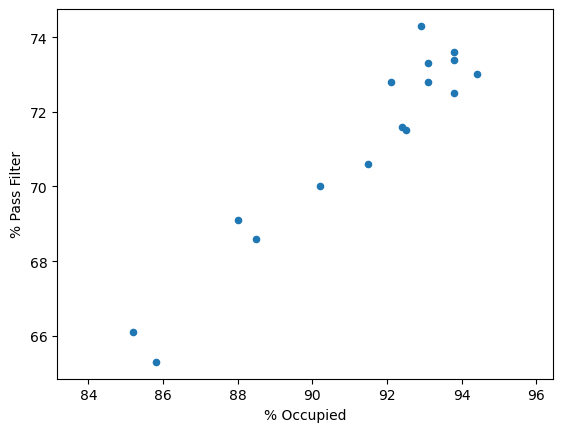

In [6]:
ax = (pd.DataFrame(ar)[['Lane', 'Tile', '% Pass Filter', '% Occupied']]
    .drop_duplicates()
    .plot(kind='scatter', x='% Occupied', y='% Pass Filter'))
ax.axis('equal')
ax.figure.show()

The straight line with a positive slope suggests that the run is potentially underloaded. See the following references:
- Illumina Support: [Diagnosing Suboptimal Clustering (Patterned Flow Cells)](https://support-docs.illumina.com/SHARE/ClusterOptimize/Content/SHARE/ClusterOptimize/DiagnosingSuboptimalPatterned.htm)
- Illumina YouTube[Sequencing: Optimizing Cluster Density](https://www.youtube.com/watch?v=QnMKfWbk_hY)

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1Ci9U9tpF2LHNAjo2kia5OmrYLbqrU4G0cV7wYBmSFUM/)
- [Library sheet](https://docs.google.com/spreadsheets/d/1vbDw1RuiNfsFqH4rQNsFWS0Mi73PiCcIHfJc9QmOIe8/)
- [Benchling notebook](https://benchling.com/s/etr-fV6EV9txrU2wIEb8MfxX)

In [7]:
regex_fastq_files = re.compile((
    r'(?P<filename>BTY_scBarcode_(?P<sample>[A-Z]\d+)_.*R(?P<read>1|2)_001.fastq.gz)'))

In [8]:
df_data = pd.DataFrame([
    regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)
        if file.endswith('.fastq.gz')]) \
    .astype(dict(read=int))

In [9]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [10]:
df_data['n_reads'] = int(0)
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [11]:
# from the library sheet, linked above
df_data['complexity_tapestation'] = df_data['sample'].map(dict(
    D1=129792,
    F1=178034,
    H1=790240,
    H2=129792,
    E5=217086,
    F5=556499,
    G5=339413))

In [12]:
df_data = df_data.sort_values(['sample', 'read']).reset_index(drop=True)
df_data

,filename,sample,read,n_reads,complexity_tapestation
0,BTY_scBarcode_D1_S3_L001_R1_001.fastq.gz,D1,1,165855,129792
1,BTY_scBarcode_D1_S3_L001_R2_001.fastq.gz,D1,2,165855,129792
2,BTY_scBarcode_E5_S7_L001_R1_001.fastq.gz,E5,1,283029,217086
3,BTY_scBarcode_E5_S7_L001_R2_001.fastq.gz,E5,2,283029,217086
4,BTY_scBarcode_F1_S4_L001_R1_001.fastq.gz,F1,1,222593,178034
5,BTY_scBarcode_F1_S4_L001_R2_001.fastq.gz,F1,2,222593,178034
6,BTY_scBarcode_F5_S8_L001_R1_001.fastq.gz,F5,1,855403,556499
7,BTY_scBarcode_F5_S8_L001_R2_001.fastq.gz,F5,2,855403,556499
8,BTY_scBarcode_G5_S9_L001_R1_001.fastq.gz,G5,1,433572,339413
9,BTY_scBarcode_G5_S9_L001_R2_001.fastq.gz,G5,2,433572,339413


In [13]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)

Total number of paired reads: 3339282


# FastQC

In [14]:
%%bash -s {DIR_DATA} {DIR_AUX}
DIR_DATA="$1"
DIR_AUX="$2"
source ~/.bashrc
conda activate chipdip
DIR_FASTQC_OUT="$DIR_AUX/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_AUX/fastqc"
    cd "$DIR_DATA"
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Count barcodes

## Splitcode

1. Add barcode and UMI to read name

   `@read::[OligoRC][R1Top][R2Top][R3Top][NYStgBot][R3Bot][R2Bot][R1Bot][Oligo] RX:Z:<oligo ID + UMI>`

2. Calculate barcode counts

### Config file

- Copied from `20230831_scBarcode` experiment.
- Only checks for terminal tag from read 2 (`NYStgBot`), not read 1 (`NYLigOddStgTop`).
  - Note that the unique sequence of terminal tags need to be perfect matches. The minimum Hamming distance between two terminal tag unique sequences is <= 2 (for example, compare

    ```
    NYStgBot_51 = CTCTGTTGTTGC
    NYStgBot_52 = CTCTGTTGTTTG
    ```
    
    Consequently a sequence like `CTCTGTTGTTGG` would be a Hamming distance of 1 away from both, leading to collisions if a Hamming distance of 1 is allowed in the config file.

In [132]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-oligo_cell_barcode_short.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [133]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [135]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Run splitcode

In [16]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

for path_R1 in "$DIR_DATA"/*R1_001.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '[D-H][0-9]+')"
    path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
    PATH_MAPPING="${DIR_AUX}/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="${DIR_AUX}/summary-${SAMPLE}.json"
    PATH_OUTPUT="${DIR_PROC}/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ] || true; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
            --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
            --select=0 --pipe "$path_R1" "$path_R2" |
        awk '$1 ~ /^>/' |
        pigz -p 8 > "$PATH_OUTPUT"
    fi
done

Proportion of reads from each sample that were properly barcoded (considered "assigned" by splitcode)

In [17]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    mask_sample = df_data['sample'] == sample
    n_reads = df_data.loc[mask_sample, 'n_reads'].iloc[0]
    path_summary = os.path.join(DIR_AUX, f'summary-{sample}.json')
    with open(path_summary, 'rt') as f:
        summary = json.load(f)
    assert summary['n_processed'] == n_reads
    df_data.loc[mask_sample, 'n_assigned'] = summary['n_assigned']

In [18]:
(df_data[['sample', 'n_reads', 'n_assigned']].drop_duplicates()
    .set_index('sample')
    .pipe(lambda df: df.assign(prop_assigned=df['n_assigned'] / df['n_reads']))['prop_assigned'])

sample
D1    0.848784
E5    0.868922
F1    0.682632
F5    0.828351
G5    0.852484
H1    0.845445
H2    0.850106
Name: prop_assigned, dtype: float64

## Parse identified barcodes to counts

Structure of `sample_barcode_counts` dictionary
- key: sample
- value: `sample_data`
  - key: barcode
  - value: `barcode_data`
    - key: UMI
    - value: count

In [19]:
regex_oligo_cell_barcode = re.compile((
    r'\[OligoRC_(?P<R1_oligo>bc\d)\]'
    r'\[R1Top_(?P<R1_R1>\d+)\]'
    r'\[R2Top_(?P<R1_R2>\d+)\]'
    r'\[R3Top_(?P<R1_R3>\d+)\]'
    r'(?P<barcode>'
    r'\[NYStgBot_(?P<R2_Y>\d+)\]'
    r'\[R3Bot_(?P<R2_R3>\d+)\]'
    r'\[R2Bot_(?P<R2_R2>\d+)\]'
    r'\[R1Bot_(?P<R2_R1>\d+)\])'
    r'\[Oligo_(?P<R2_oligo>bc\d)\]'))
regex_umi = re.compile(r'RX:Z:([ATCG]+)')

In [20]:
sample_barcode_counts = dict()
sample_barcode_inconsistencies = []
path_barcode_inconsistencies = os.path.join(DIR_PROC, 'barcode_inconsistencies.csv')
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    path_barcode_counts = os.path.join(DIR_PROC, f'barcode_counts-{sample}.json.gz')
    if not os.path.exists(path_barcode_counts) or True:
        sample_data = dict()
        different_R1_R2_tags = 0
        no_match = 0
        with gzip.open(path_read_barcodes, 'rt') as f:
            for name in f:
                name = name.strip()
                match = regex_oligo_cell_barcode.search(name)
                if match:
                    tags = match.groupdict()
                    if (tags['R1_oligo'] != tags['R2_oligo']) or \
                       (tags['R1_R1'] != tags['R2_R1']) or \
                       (tags['R1_R2'] != tags['R2_R2']) or \
                       (tags['R1_R3'] != tags['R2_R3']):
                        different_R1_R2_tags += 1
                    else:
                        barcode = tags['barcode']
                        umi = regex_umi.search(name).group(1)
                        if barcode not in sample_data:
                            sample_data[barcode] = collections.defaultdict(int)
                        sample_data[barcode][umi] += 1
                else:
                    no_match += 1
        with gzip.open(path_barcode_counts, 'wt') as f:
            json.dump(sample_data, f)
        sample_barcode_inconsistencies.append({
            'sample': sample,
            'different_R1_R2_tags': different_R1_R2_tags,
            'no_match': no_match})
    else:
        print(f'{sample}: loading existing counts')
        with gzip.open(path_barcode_counts, 'rt') as f:
            sample_data = json.load(f)
    sample_barcode_counts[sample] = sample_data

In [21]:
if len(sample_barcode_inconsistencies) > 0:
    sample_barcode_inconsistencies = pd.DataFrame(sample_barcode_inconsistencies)
    sample_barcode_inconsistencies.to_csv(path_barcode_inconsistencies)
else:
    sample_barcode_inconsistencies = pd.read_csv(path_barcode_inconsistencies)

In [22]:
print('different_R1_R2_tags = reads with different barcodes detected in read 1 vs. read 2')
print('no_match = reads with missing tags')
display(sample_barcode_inconsistencies)

different_R1_R2_tags = reads with different barcodes detected in read 1 vs. read 2
no_match = reads with missing tags


,sample,different_R1_R2_tags,no_match
0,D1,0,0
1,E5,0,0
2,F1,0,0
3,F5,4,0
4,G5,0,0
5,H1,3,0
6,H2,0,0


In [23]:
print(
    'Total number of read pairs with correct barcode structure:',
    sum(
        sum(barcode_data.values())
        for sample_data in sample_barcode_counts.values()
        for barcode_data in sample_data.values()))

Total number of read pairs with correct barcode structure: 2783185


### Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [[barcode + UMI]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `NYLigOdd`, `oligo`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts (both undeduplicated and deduplicated by UMI) per [[barcode]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `NYLigOdd`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: counts per [[tag]]
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count`

In [25]:
oligorc_seqs = (
    df_config
    .loc[df_config['groups'] == 'OligoRC']
    .pipe(lambda df: df.assign(ids=df['ids'].str.replace('OligoRC_', '')))
    .set_index('ids')['tags']).to_dict()
seq_to_oligorc = {v[:9]: k for k, v in oligorc_seqs.items()}

In [41]:
df_umi_counts = []
for sample, sample_data in sample_barcode_counts.items():
    for barcode, barcode_data in sample_data.items():
        for umi, count in barcode_data.items():
            df_umi_counts.append([sample, barcode, umi, count])
df_umi_counts = pd.DataFrame(df_umi_counts, columns=['sample', 'barcode', 'umi', 'count']) \
    .astype(dict(sample='category'))
df_umi_counts['oligo'] = df_umi_counts['umi'].str[:9].map(seq_to_oligorc).astype('category')
df_umi_counts['umi'] = df_umi_counts['umi'].str.replace(f"^({'|'.join(oligorc_seqs.values())})", '', regex=True)

In [42]:
df_umi_counts = pd.concat(
    (
        df_umi_counts.drop(columns='barcode'),
        df_umi_counts["barcode"].str.extract((
            r"\[NYStgBot_(?P<NYLigOdd>\d+)\]"
            r"\[R3Bot_(?P<R3>\d+)\]"
            r"\[R2Bot_(?P<R2>\d+)\]"
            r"\[R1Bot_(?P<R1>\d+)\]"
        ))),
    axis=1
).astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8, NYLigOdd=np.uint8))

Remove barcodes corresponding to "contaminating" NYLigOdd tags that were not from the set of actual tags used. (These were really rare in this dataset.)

In [43]:
mask_contaminating_term = (df_umi_counts['NYLigOdd'] < 49) | (df_umi_counts['NYLigOdd'] > 71)
print('Number of contaminated barcodes:', mask_contaminating_term.sum())
print('Number of contaminated reads:', df_umi_counts.loc[mask_contaminating_term, 'count'].sum())

Number of contaminated barcodes: 39
Number of contaminated reads: 61


In [44]:
df_umi_counts = df_umi_counts.loc[~mask_contaminating_term].copy()

In [49]:
df_barcode_counts = (
    df_umi_counts.groupby(["sample"] + ROUNDS, observed=True)["count"]
    .agg(["count", "sum"])
    .reset_index()
    .rename(columns={"count": "count_dedup", "sum": "count"})
)

In [56]:
df_tag_counts = (
    df_barcode_counts
    .melt(
        id_vars=["sample", "count", "count_dedup"],
        value_vars=ROUNDS,
        var_name="round",
        value_name="tag")
    .groupby(["sample", "round", "tag"], observed=True)
    .agg({"count": "sum", "count_dedup": "sum"})
    .reset_index()
    .rename(columns={"count": "no", "count_dedup": "yes"})
    .melt(
        id_vars=["sample", "round", "tag"],
        value_vars=["yes", "no"],
        var_name="deduplication",
        value_name="count")
    .astype(dict(round="category", deduplication="category")))

In [329]:
# df_tag_counts = (
#     df_barcode_counts
#     .melt(
#         id_vars=["sample", "count", "count_dedup"],
#         value_vars=rounds,
#         var_name="round",
#         value_name="tag")
#     .groupby(["sample", "round", "tag"], observed=True)
#     .agg({"count": "sum", "count_dedup": "sum"})
#     .reset_index()
#     .rename(columns={"count": "no", "count_dedup": "yes"})
#     .melt(
#         id_vars=["sample", "round", "tag"],
#         value_vars=["yes", "no"],
#         var_name="deduplication",
#         value_name="count")
#     .astype(dict(round="category", deduplication="category"))
#     .pipe(
#         lambda df: df.loc[
#             ((df["round"] == "NYLigOdd") & (df["tag"].isin(range(49, 72)))) |
#             ((df["round"].isin(("R1", "R2", "R3"))) & (df["tag"].isin(range(1, 25))))])
#     .astype(dict(round="category", deduplication="category"))
#     .reset_index(drop=True))

### Check for tags that are missing from this dataset

The missing R1 and R2 tags correspond *exactly* to circled wells on the SPRITE Zero tag plate.

- R1: {9, 12, 16, 19, 21, 23}
- R2: {10, 20, 22}
- R3: {24}
- NYLigOdd: {60}

In [141]:
expected_tags = {
    'R1': set(range(1, 25)),
    'R2': set(range(1, 25)),
    'R3': set(range(1, 25)),
    'NYLigOdd': set(range(49, 72))}

In [142]:
df_missing_tags = []
assert (df_tag_counts['count'] > 0).all()
for sample, group in df_tag_counts.groupby('sample'):
    for r in ROUNDS:
        missing_tags = expected_tags[r] - set(group.loc[group['round'] == r, 'tag'])
        rare_tags = set(group.loc[
            (group['round'] == r) &
            (group['deduplication'] == 'yes') &
            (group['count'] > 0) &
            (group['count'] < 50),
            'tag'])
        assert len(missing_tags & rare_tags) == 0
        df_missing_tags.append(dict(
            sample=sample,
            round=r,
            missing_tags=missing_tags,
            rare_tags=rare_tags))
df_missing_tags = pd.DataFrame(df_missing_tags).sort_values(['round', 'sample'])
df_missing_tags

,sample,round,missing_tags,rare_tags
3,D1,NYLigOdd,{60},{}
7,E5,NYLigOdd,{60},{}
11,F1,NYLigOdd,{60},{}
15,F5,NYLigOdd,{60},{}
19,G5,NYLigOdd,{60},{}
23,H1,NYLigOdd,{},{60}
27,H2,NYLigOdd,{60},{}
0,D1,R1,"{9, 12, 16, 19, 21, 23}",{}
4,E5,R1,"{9, 12, 16, 19, 21, 23}",{}
8,F1,R1,"{9, 12, 16, 21, 23}",{19}


#### `grep` for these missing tags in the raw data

Result: these tags are truly missing

In [146]:
popen_grep = []
for r in ROUNDS:
    missing_tags = set().union(
        *df_missing_tags.loc[
            df_missing_tags["round"] == r, ["missing_tags", "rare_tags"]
        ]
        .stack()
        .to_list()
    )
    if r == 'NYLigOdd':
        missing_ids = [f'NYStgBot_{tag}' for tag in missing_tags]
        read = 2
    else:
        missing_ids = [f'{r}Top_{tag}' for tag in missing_tags]
        read = 1
    # grep for them in the sequencing data
    for missing_id in missing_ids:
        tag_seq = df_config.loc[df_config['ids'] == missing_id, 'tags'].item()
        for sample in df_data['sample'].unique():
            path_fastq = os.path.join(
                DIR_DATA,
                df_data.loc[
                    (df_data['sample'] == sample) & (df_data['read'] == read),
                    'filename'].item())
            if r == 'NYLigOdd':
                cmd = (
                    f'unpigz -c "{path_fastq}" | '
                    "awk '{if (NR % 4 == 2) print substr($0, 1, 13)}' | "
                    f'grep "{tag_seq}" | wc -l')
            else:
                cmd = (
                    f'unpigz -c "{path_fastq}" | '
                    "awk '{if (NR % 4 == 2) print $0}' | "
                    f'grep "{tag_seq}" | wc -l')
            popen = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
            popen_grep.append((r, missing_id, sample, popen))

In [147]:
df_grep = []
for (r, missing_id, sample, popen) in popen_grep:
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_grep.append((r, missing_id, sample, int(count.decode().strip())))
df_grep = pd.DataFrame(df_grep, columns=['round', 'tag', 'sample', 'count'])

In [148]:
with pd.option_context('display.max_rows', 100):
    display(df_grep)

,round,tag,sample,count
0,R1,R1Top_9,D1,0
1,R1,R1Top_9,E5,0
2,R1,R1Top_9,F1,0
3,R1,R1Top_9,F5,0
4,R1,R1Top_9,G5,0
5,R1,R1Top_9,H1,1
6,R1,R1Top_9,H2,0
7,R1,R1Top_12,D1,0
8,R1,R1Top_12,E5,0
9,R1,R1Top_12,F1,0


##### Troubleshoot missing tags

Why does sample F1 have 1157 reads with tag `NYStgBot_60`, yet `NYStgBot_60` is considered a missing tag for sample F1? (In other words, why does the `splitcode` output for sample F1 not include a single fully-barcoded read containing tag `NYStgBot_60`?)

Because no read 1 reads from sample F1 contain `NYLigOddStgTop_60` (within the location constraints in the config file).

In [173]:
%%bash -s {DIR_DATA}
DIR_DATA="$1"
path_R1="${DIR_DATA}/BTY_scBarcode_F1_S4_L001_R1_001.fastq.gz"
NYLigOddStgTop_60="AGTTGTCCGCAAGTGCTGG"
unpigz -c "$path_R1" | grep "$NYLigOddStgTop_60"
if [ "$?" -eq 1 ]; then echo "Sequence not found"; fi

Sequence not found


What do read 1 and read 2 look like when read 2 contains a full barcode with `NYStgBot_60`, but read 1 does not match `NYLigOddStgTop_60`?
- Read `FS10000829:138:BTR67713-1618:1:1111:8580:1710`: `R3Top_3` is followed (ligated) by `EvenTop_54`, which is followed by `NYLigEvenStgTop_60`
- Read `FS10000829:138:BTR67713-1618:1:1114:5200:3040`: `R3Top_7` is followed (ligated) by `EvenTop_67`, which is followed by `NYLigEvenStgTop_60`
- Read `FS10000829:138:BTR67713-1618:1:1116:4880:1690`: `R3Top_7` is followed (ligated) by `EvenTop_45`, which is followed by `NYLigEvenStgTop_60`

In [174]:
path_config_nystgbot60 = os.path.join(DIR_AUX, 'splitcode_config-NYStgBot_60.tsv')

In [181]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config_nystgbot60}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

SAMPLE="F1"
path_R1="$(ls "$DIR_DATA"/*${SAMPLE}*R1_001.fastq.gz)"
path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
PATH_MAPPING="${DIR_AUX}/mapping-NYStgBot_60-${SAMPLE}.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-NYStgBot_60-${SAMPLE}.json"
PATH_OUTPUT_R1="${DIR_AUX}/out_R1-NYStgBot_60-${SAMPLE}.fastq"
PATH_OUTPUT_R2="${DIR_AUX}/out_R2-NYStgBot_60-${SAMPLE}.fastq"

if [ ! -f "$PATH_OUTPUT" ] || true; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --loc-names --no-outb -t 8 \
        --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
        --output="$PATH_OUTPUT_R1","$PATH_OUTPUT_R2" \
        "$path_R1" "$path_R2"
fi

* Using a list of 155 tags (vector size: 306; map size: 169,817; num elements in map: 200,558)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231002/BTY_scBarcode_F1_S4_L001_R1_001.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20231002/BTY_scBarcode_F1_S4_L001_R2_001.fastq.gz
* processing the reads ...
done 
* processed 222,593 reads, 3 reads were assigned


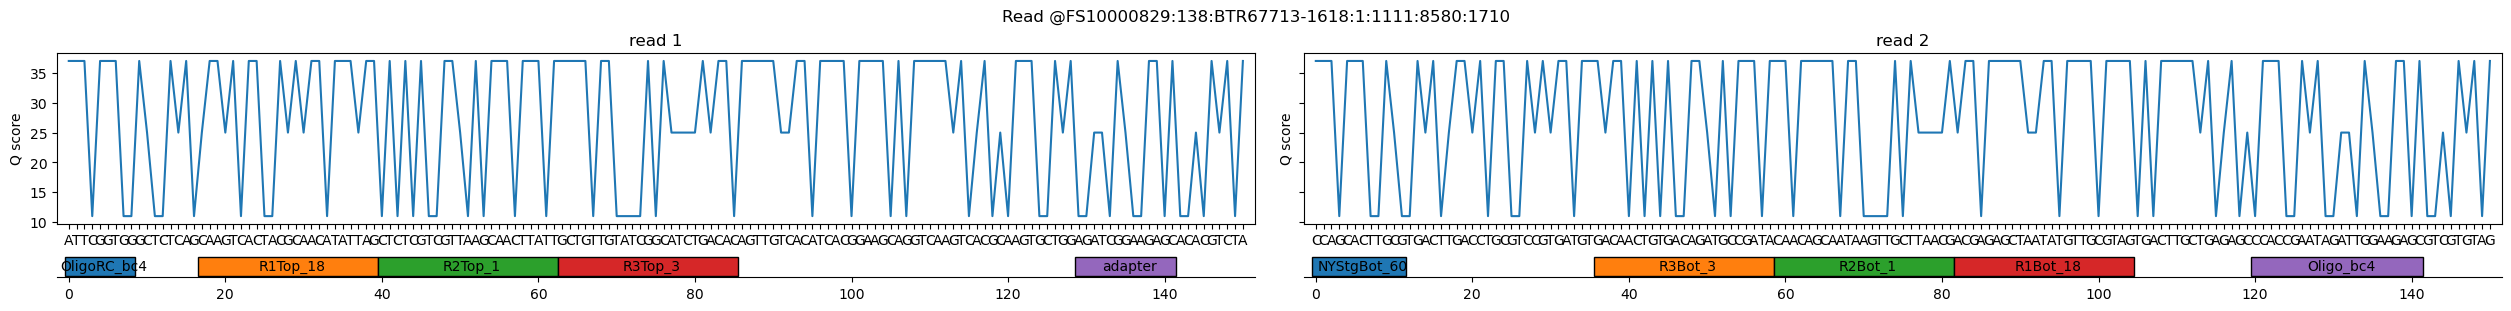

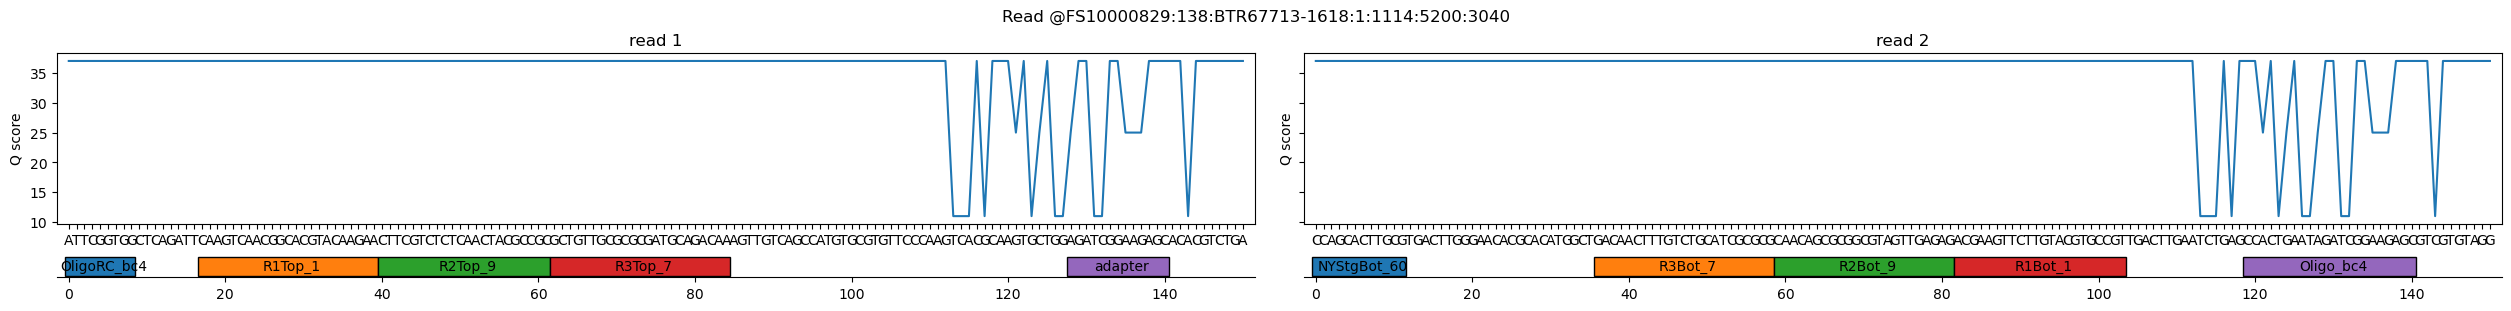

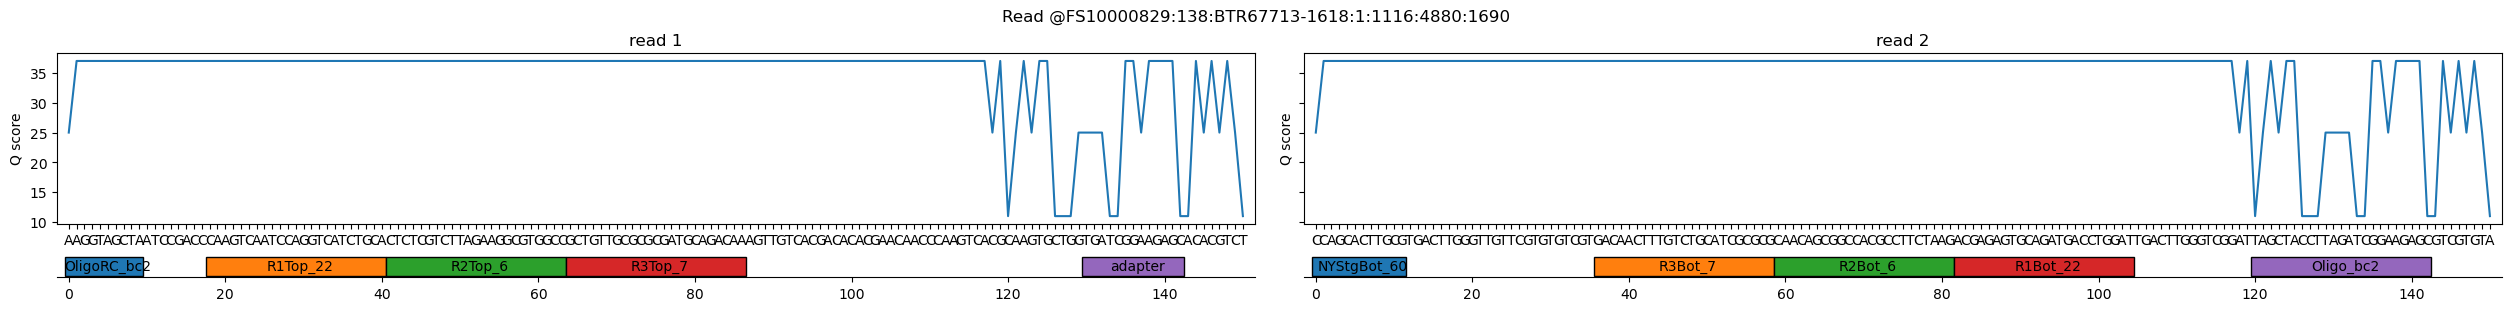

In [195]:
with open(os.path.join(DIR_AUX, 'out_R1-NYStgBot_60-F1.fastq'), 'rt') as f1, \
     open(os.path.join(DIR_AUX, 'out_R2-NYStgBot_60-F1.fastq'), 'rt') as f2:
    for (name1, seq1, _, quals1), (name2, seq2, _, quals2) in zip(
        helpers.fastq_parse(f1),
        helpers.fastq_parse(f2)):
        plot_features.plot_read_pair(name1, seq1, quals2, seq2, quals2, reverse2=False, fig_kws=dict(figsize=(25, 3)))

# Sequencing Depth and Duplicates

## Oligo and UMI distribution

The distribution

In [203]:
with pd.option_context('display.float_format', '{:,g}'.format):
    display(df_umi_counts['count'].describe())

count   2.17783e+06
mean        1.27793
std         0.57677
min               1
25%               1
50%               1
75%               1
max              12
Name: count, dtype: float64

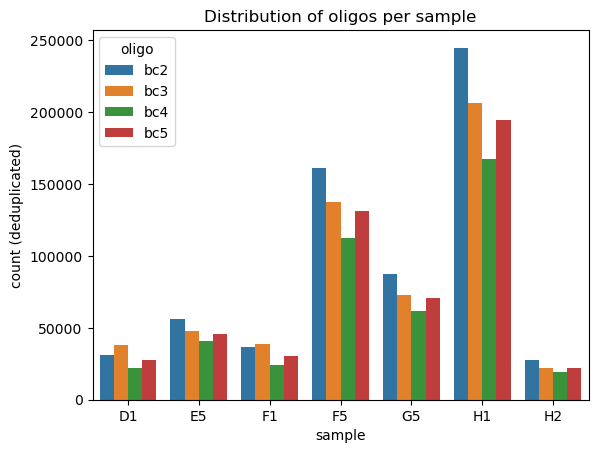

In [431]:
ax = sns.barplot(
    (
        df_umi_counts
        .groupby(['sample', 'oligo'])['count']
        .agg(['size', 'sum'])
        .reset_index()
        .rename(columns=dict(size='count (deduplicated)'))),
    x='sample',
    y='count (deduplicated)',
    hue='oligo')
ax.set_title('Distribution of oligos per sample')
ax.figure.show()

Distribution of UMIs per oligo per sample

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


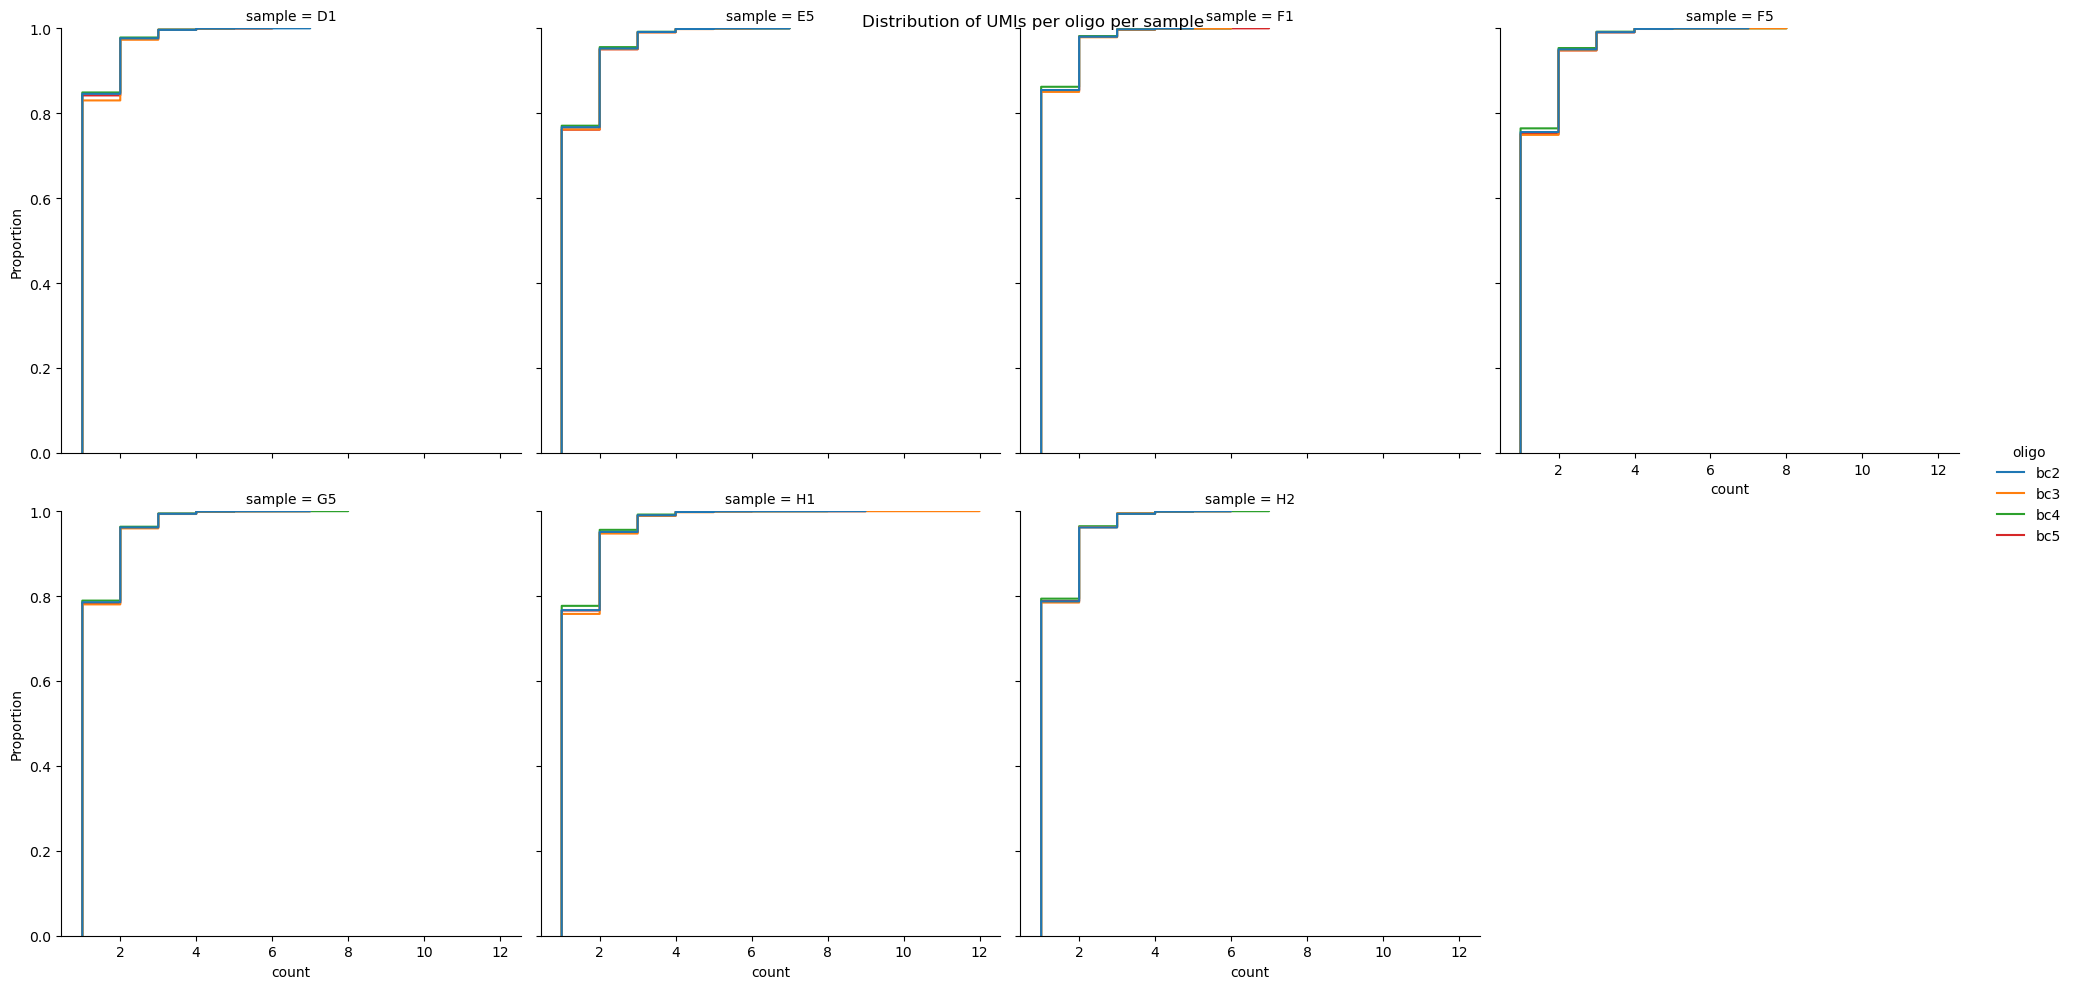

In [440]:
g = sns.displot(
    df_umi_counts,
    kind='ecdf',
    x='count',
    hue='oligo',
    col='sample',
    col_wrap=4)
g.figure.suptitle('Distribution of UMIs per oligo per sample')
g.figure.show()

### Estimate library complexity from sequencing/UMI duplicates

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [238]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*2)
    )
    assert res.fun < max_err
    return res.x

In [222]:
umi_complexity = 4 * 4**8
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 262144


#### Option 1: From all barcodes per sample

In [220]:
complexity_umi_all = df_barcode_counts.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

#### Option 2: From predominant barcode per sample

In [242]:
top_barcode_counts = (
    df_barcode_counts
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.loc[group["count"] == group["count"].max(), ["count", "count_dedup"]])
    .droplevel(1, axis=0))

,count,count_dedup
sample,,
D1,1087,903
E5,30752,22348
F1,271,224
F5,1508,1147
G5,238,188
H1,64942,44354
H2,10581,8321


In [240]:
complexity_umi_top = top_barcode_counts.apply(
    lambda s: estimate_library_complexity(s["count"], s["count_dedup"]), axis=1))

#### Plot

In [250]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename("complexity_umi_top"),
            complexity_umi_all.rename("complexity_umi_all"),
        ),
        axis=1,
    ).reset_index(),
    how="left",
    on="sample",
)

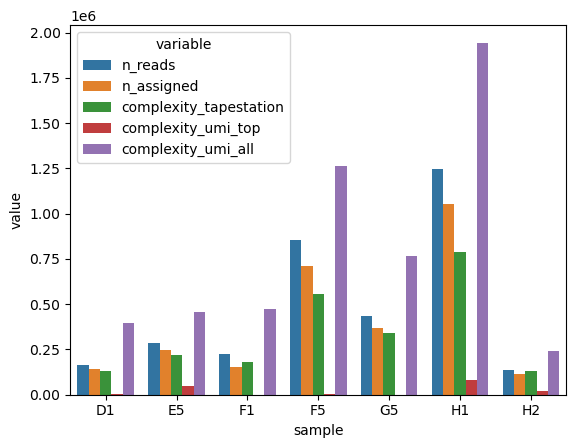

In [251]:
ax = sns.barplot(
    df_data[['sample', 'n_reads', 'n_assigned', 'complexity_tapestation', 'complexity_umi_top', 'complexity_umi_all']] \
        .drop_duplicates() \
        .melt(id_vars='sample'),
    x='sample',
    y='value',
    hue='variable')

#### Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `complexity_tapestation` molecules.

In [258]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation']),
        axis=1) \
    .rename('coverage')

sample
D1    0.661971
E5    0.677893
F1    0.574072
F5    0.720086
G5    0.663440
H1    0.735902
H2    0.585161
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [274]:
df_barcode_counts.groupby('sample')[['count_dedup', 'count']].sum().pipe(
    lambda df: df.assign(**{
        'duplication rate': (df['count'] - df['count_dedup'])/df['count_dedup']}))

,count_dedup,count,duplication rate
sample,,,
D1,118463,140772,0.188320
E5,190187,245930,0.293096
F1,130029,151910,0.168278
F5,542612,708564,0.305839
G5,293059,369608,0.261207
H1,812562,1052141,0.294844
H2,90919,114199,0.256052


In [289]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s:
            scipy.stats.binom.mean(n=s['n_assigned'], p=1/s['complexity_tapestation']) / \
            (1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation'])),
        axis=1) \
    .map(lambda s: (s - 1) / s) \
    .rename('duplication rate')

sample
D1    0.389675
E5    0.401614
F1    0.327377
F5    0.434460
G5    0.390768
H1    0.447286
H2    0.334940
Name: duplication rate, dtype: float64

# Ligation QC

| Round    | Tags used (wells) | Tags used (ID) | Tags added during pooling |
| -------- | ----------------- | -------------- | ------------------------- |
| R1       | A1-A11, B1-B11    | 1-11, 13-23    | A12 (12), B12 (24)        |
| R2       | C1-C12, D3-D12    | 1-12, 15-24    | D1-D2 (13-14)             |
| R3       | E1-E12, F1-F9     | 1-21           | F10-F12 (22-24)           |
| NYLigOdd | E1-E12, F1-F10    | 49-70          | F11 (71)                  |

In [312]:
rounds_to_pooled_tags = {
    'R1': (12, 24),
    'R2': (13, 14),
    'R3': (22, 23, 24),
    'NYLigOdd': (71,)
}

Expected coverage and duplication rate

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


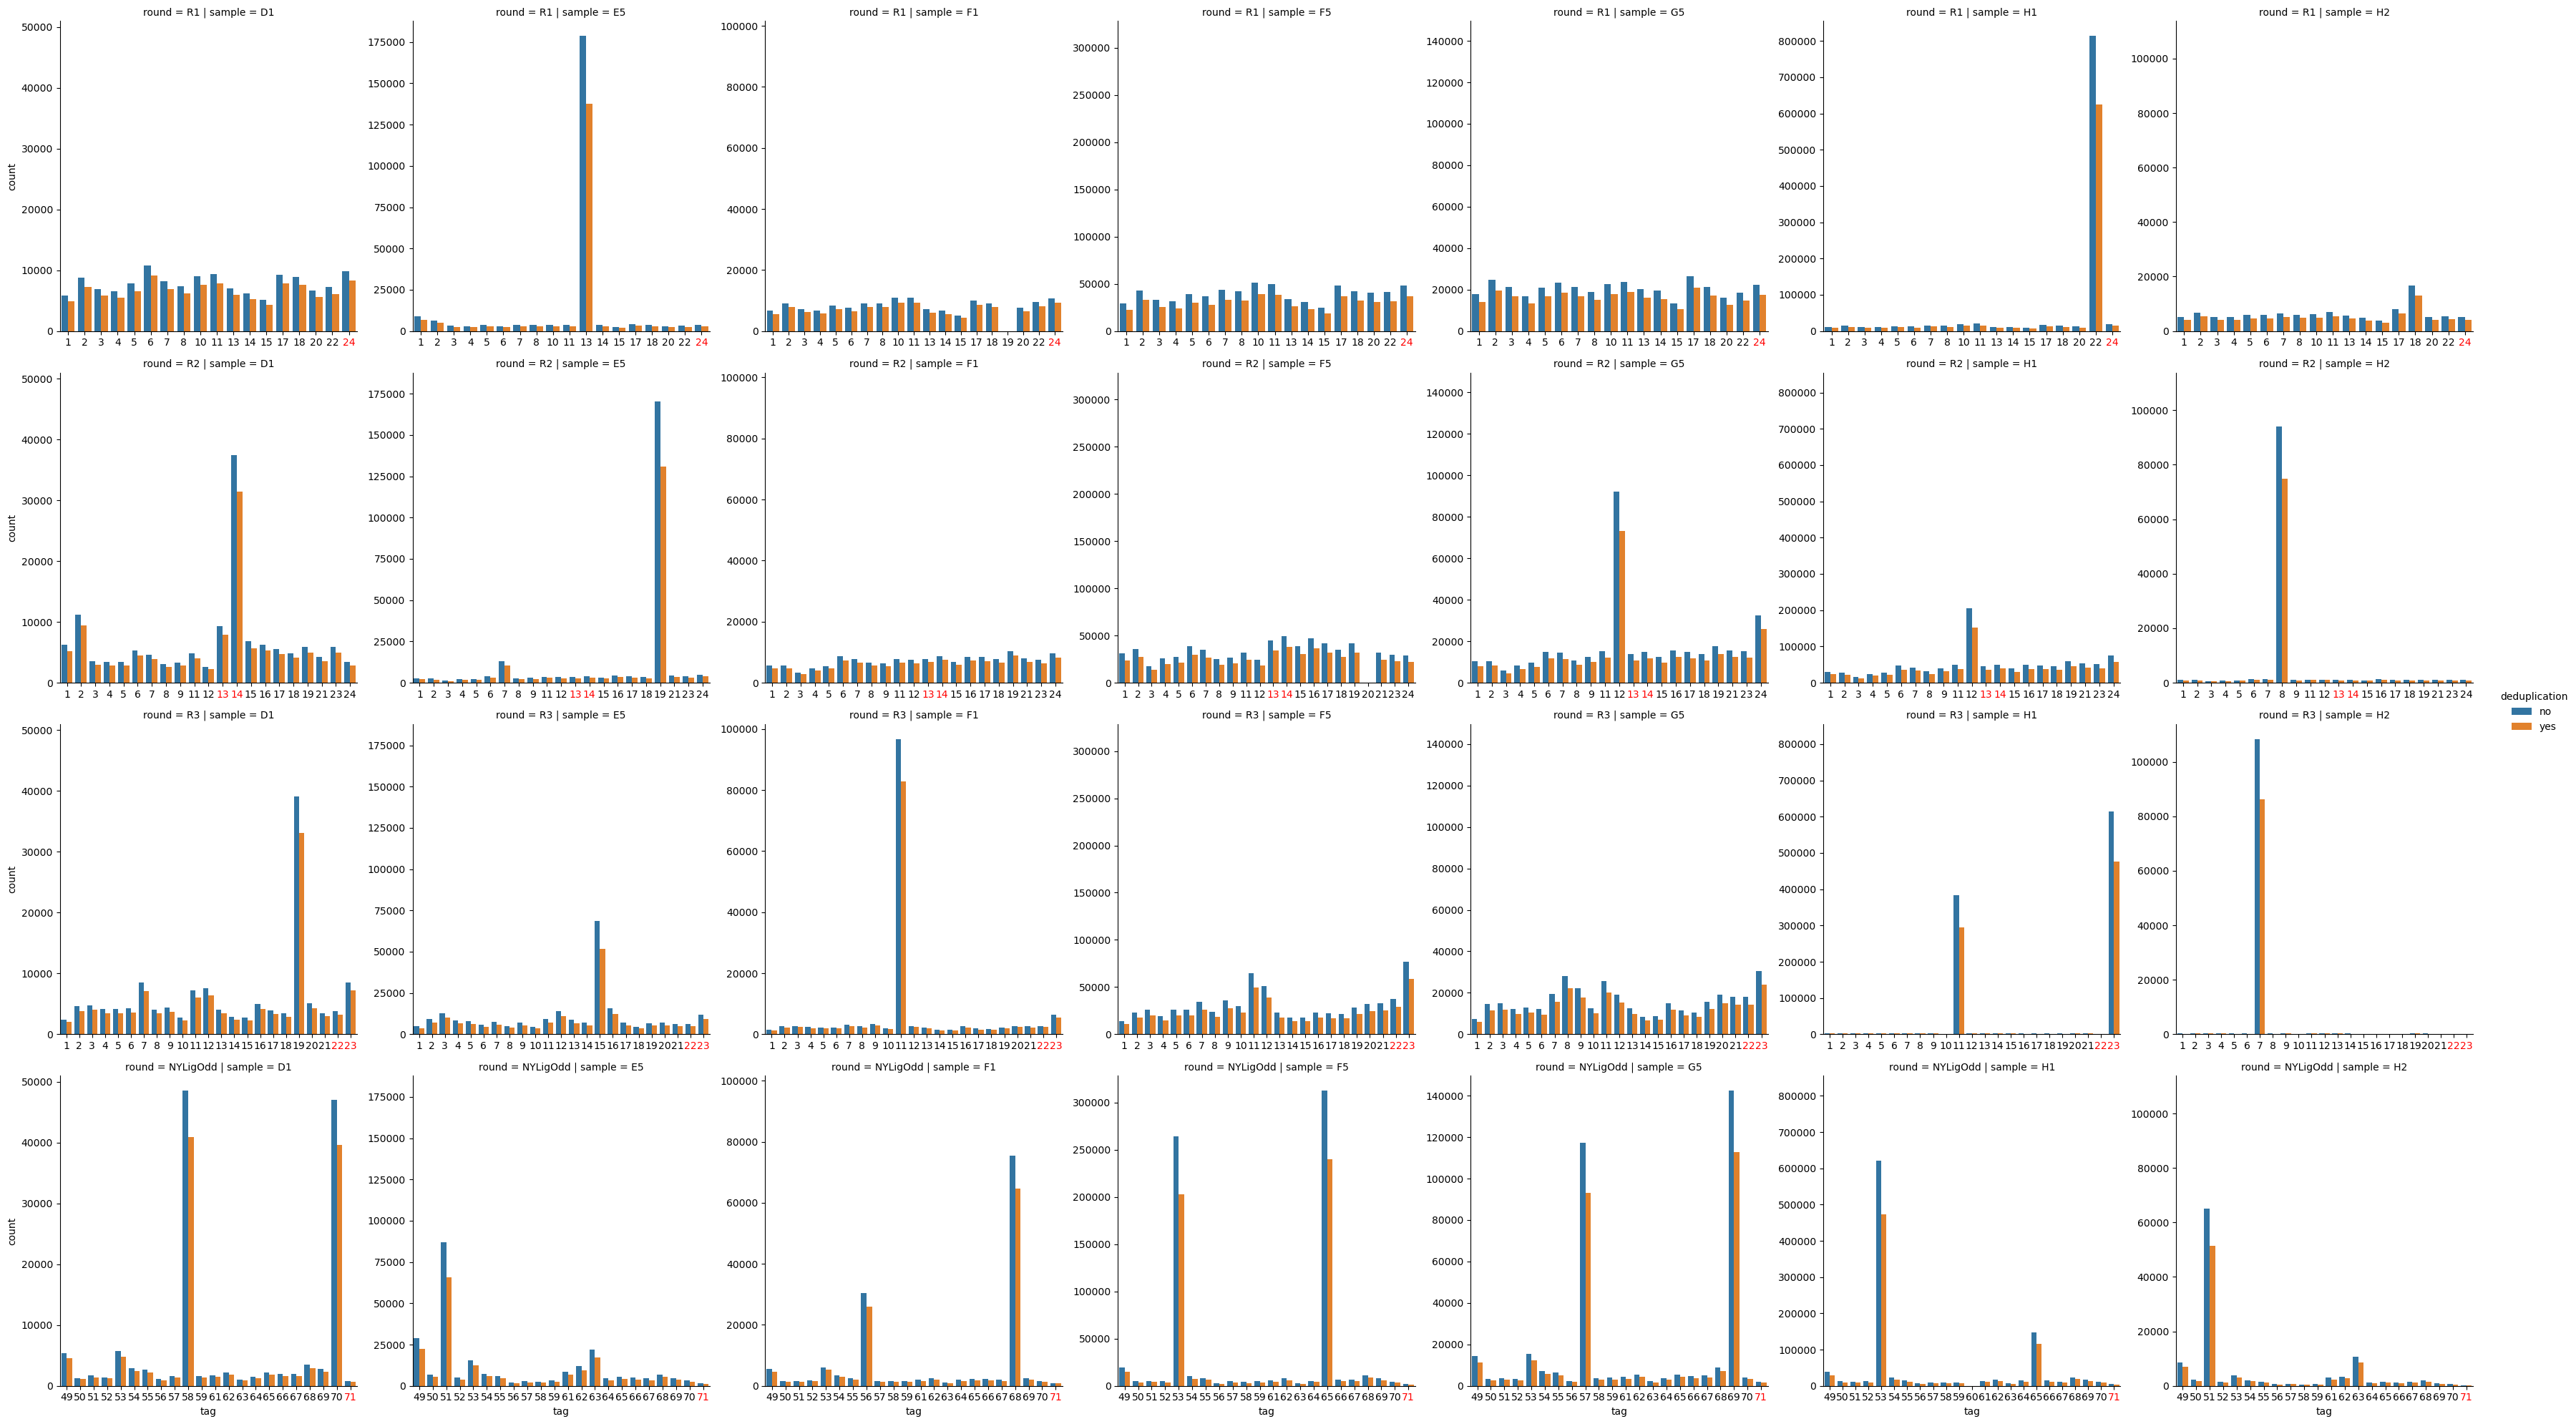

In [315]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='deduplication',
    col='sample',
    sharex=False,
    sharey='col')

# red color for xticklabels corresponding to tags added during pooling
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) in rounds_to_pooled_tags[r]:
            text.set_color('red')

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300)

Observations
- In any subplot with 2 "peaks", the peaks are 12 indices apart (one row apart on the tag plates), consistent with ligation of another tag upon pooling. (I pooled by first using a multichannel pipette to transfer 1 row into the next row, then individually pooling the wells across the row.)

Interpretation
- Samples without a "peak" in rounds R1 or R2 may correspond to nuclei that ended up in an "empty" well with no tag. Consequently, upon pooling, they received an even distribution of the other tags.
- Overall, ligation by a "pooled tag" was no higher than other background, suggesting that cross-ligation is not a major issue.
- The frequency of 2 peaks on the NYLigOdd round may be due to use of insufficient molar amount of NYLigOdd (2 uL 4 uM R3 tags, then 3 uL 4.5 uM NYLigOdd). This may explain why the tags 1 row apart appear to peak together.

## Ligation of pooled tags

1. (Distribution over samples) For a given round, what proportion of tags were pooled tags?
2. (Distribution over samples) For a given round, what proportion of tags were accounted by each pooled tag?
4. (Distribution over samples) For a given partial (3 out of 4 rounds) barcode, what proportion of the "missing" round is made up of pooled tags?

In [310]:
df_pooled_tags_counts = (
    df_tag_counts
    .groupby(["sample", "round", "deduplication"], group_keys=False)
    .apply(lambda group: (
        group
        .assign(total=group["count"].sum())
        .loc[group["tag"].isin(rounds_to_pooled_tags[group.iloc[0]["round"]])]))
    .pipe(lambda df: df.assign(proportion=df['count']/df['total']))
    .sort_values(['deduplication', 'round', 'sample', 'proportion'])
    .reset_index(drop=True)
)

In [322]:
# assert that the number of counts observed at each round is the same for all samples
assert df_pooled_tags_counts.groupby(['sample', 'deduplication'])['total'].agg(lambda x: len(np.unique(x)) == 1).all()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


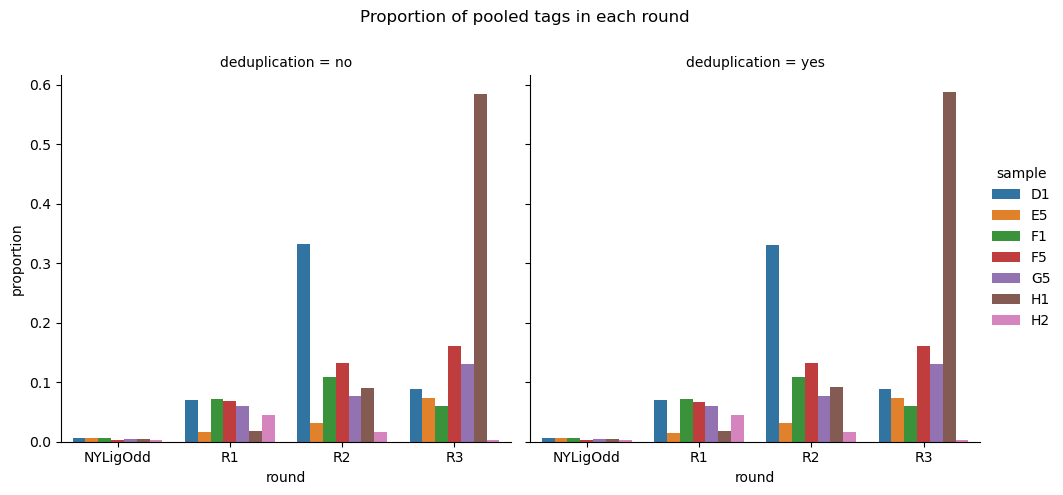

In [349]:
g = sns.catplot(
    df_pooled_tags_counts.groupby(['sample', 'round', 'deduplication'], as_index=False)['proportion'].sum(),
    kind='bar',
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


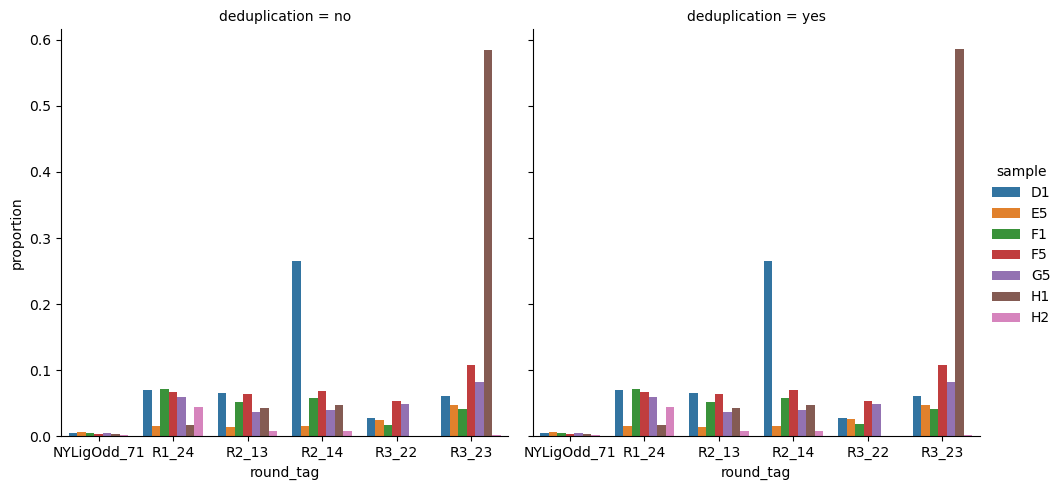

In [348]:
sns.catplot(
    df_pooled_tags_counts.assign(
        round_tag=df_pooled_tags_counts['round'].str.cat(df_pooled_tags_counts['tag'].astype(str), sep='_')),
    kind='bar',
    x='round_tag',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

In [400]:
df_pooled_tag_proportion_per_partial_barcode = []
for i in range(len(ROUNDS)):
    partial_rounds = ROUNDS[:i] + ROUNDS[i+1:]
    pooled_round = ROUNDS[i]
    df_pooled_tag_proportion_per_partial_barcode.append((
        df_barcode_counts
        .groupby(['sample'] + partial_rounds, observed=True, as_index=False)
        .apply(lambda group:
               group.loc[group[pooled_round].isin(rounds_to_pooled_tags[pooled_round]), ['count', 'count_dedup']].sum(axis=0) / 
               group[['count', 'count_dedup']].sum(axis=0))
        .assign(**{pooled_round: -1, 'round': pooled_round})
        .rename(columns={'count': 'proportion', 'count_dedup': 'proportion_dedup'})
    ))
df_pooled_tag_proportion_per_partial_barcode = pd.concat(df_pooled_tag_proportion_per_partial_barcode) \
    .astype(dict(round='category'))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


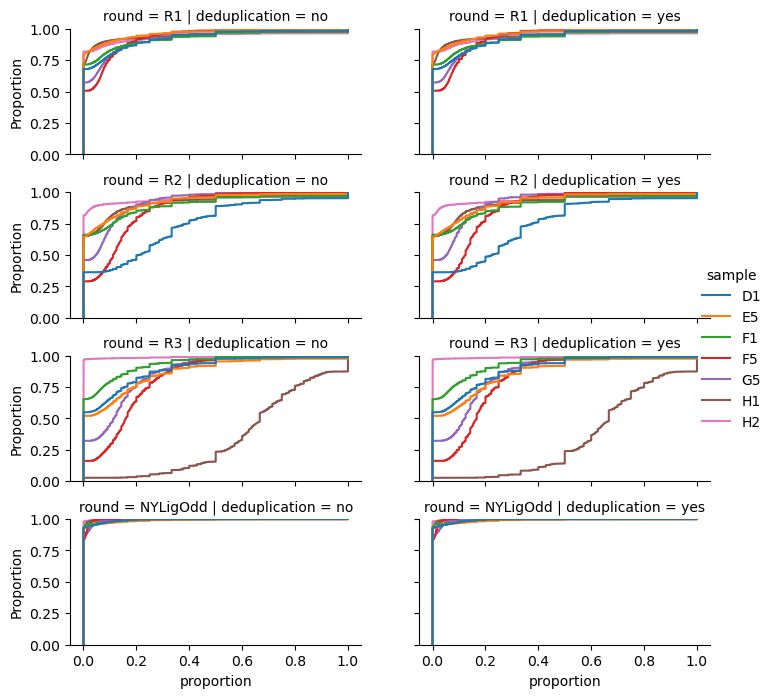

In [422]:
g = sns.displot(
    kind='ecdf',
    data=(
        df_pooled_tag_proportion_per_partial_barcode
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion')),
    x='proportion',
    hue='sample',
    row='round',
    row_order=ROUNDS,
    col='deduplication',
    facet_kws={'gridspec_kws': dict(hspace=0.3)})
g.figure.set_size_inches((8, 8))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


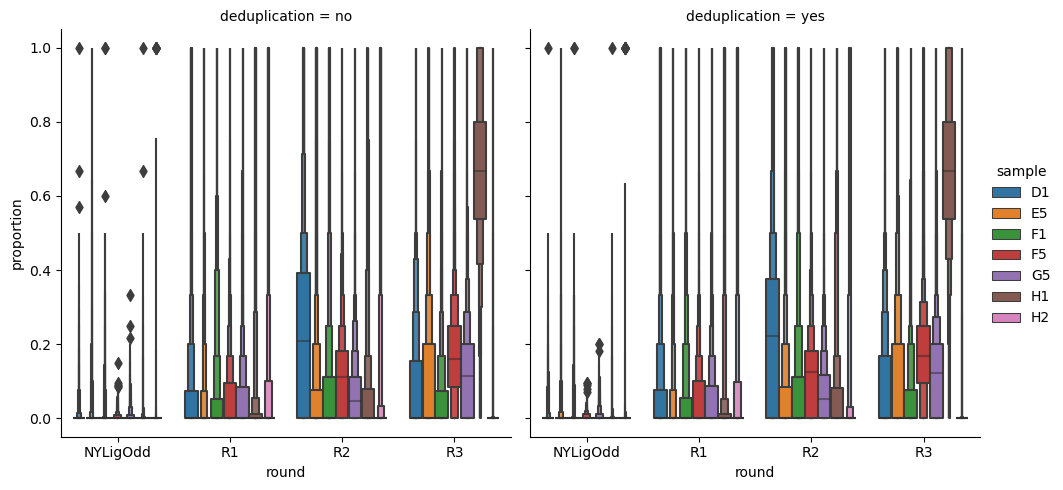

In [425]:
sns.catplot(
    kind='boxen',
    data=df_pooled_tag_proportion_per_partial_barcode \
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion'),
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')

Interpretation
- Ligation efficiency appears to decrease from R1 to R3, with greater proportion of each round accounted for by pooled tags.
  - Possible (but not fully convincing) explanation is insufficient ligase after several rounds, but this does not explain why the NYLigOdd is extraordinarily clean (almost no ligation of the pooled tag).

## Independence of each round

In [453]:
df_rounds_independence = []
for r1, r2 in itertools.combinations(ROUNDS, 2):
    for sample, group in df_barcode_counts.groupby('sample'):
        pvalue = scipy.stats.chi2_contingency((
            group
            .groupby([r1, r2], observed=True, as_index=False)['count'].sum()
            .pivot(columns=r2, index=r1)
            .fillna(0)
            .values
        )).pvalue
        df_rounds_independence.append(dict(sample=sample, r1=r1, r2=r2, pvalue=pvalue))
df_rounds_independence = pd.DataFrame(df_rounds_independence)

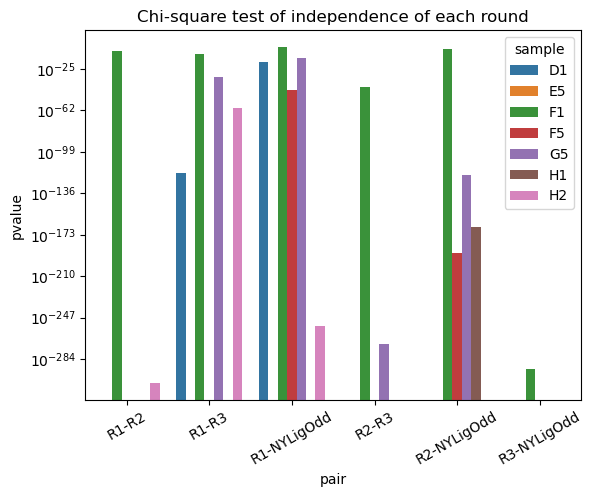

In [464]:
ax = sns.barplot(
    df_rounds_independence.assign(pair=df_rounds_independence['r1'].str.cat(df_rounds_independence['r2'], sep='-')),
    x='pair',
    y='pvalue',
    hue='sample')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=30)
ax.set_title('Chi-square test of independence of each round')
ax.figure.show()

# Analyze barcode count distributions

Structure of `dist_oligos` and `dist_unique_oligos` dictionaries
- key: sample
- value: pandas.Series of barcode counts

In [85]:
dist_oligos = {}
dist_unique_oligos = {}
for sample, sample_data in all_samples.items():
    dist_oligos[sample] = pd.Series(sum(barcode_data.values()) for barcode_data in sample_data.values())
    dist_unique_oligos[sample] = pd.Series(map(len, sample_data.values()))

In [87]:
for sample, sample_data in all_samples.items():
    print(f'Number of barcodes in sample {sample}:', len(sample_data))
    print('Frequency of most common barcodes:', dist_oligos[sample].sort_values(ascending=False).values[:10])
    print('Frequency of most common barcodes (dedup):', dist_unique_oligos[sample].sort_values(ascending=False).values[:10])
    print()

Number of barcodes in sample D1: 44298
Frequency of most common barcodes: [1087  748  556  535  514  469  467  444  442  412]
Frequency of most common barcodes (dedup): [903 627 471 448 447 406 381 372 368 352]

Number of barcodes in sample E5: 40218
Frequency of most common barcodes: [30752  4872  4461  3657  3032  2229  2076  1979  1881  1861]
Frequency of most common barcodes (dedup): [22348  3745  3476  2819  2328  1771  1637  1534  1451  1438]

Number of barcodes in sample F1: 34214
Frequency of most common barcodes: [271 255 245 227 227 225 221 219 214 211]
Frequency of most common barcodes (dedup): [224 213 210 203 196 195 187 185 184 183]

Number of barcodes in sample F5: 83204
Frequency of most common barcodes: [1508  322  192  182  181  176  174  169  167  166]
Frequency of most common barcodes (dedup): [1147  247  147  146  138  134  134  130  129  125]

Number of barcodes in sample G5: 72977
Frequency of most common barcodes: [238 214 213 210 206 196 194 191 191 189]
Freque

In [111]:
df_dist_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))


df_dist_unique_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_unique_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))

### Number of oligos per cell barcode (akin to scSPRITE Figure 1C)

In [69]:
df_dist_unique_oligos = df_dist_unique_oligos.groupby('sample', group_keys=False) \
    .apply(lambda group: group.sort_values('oligos per cell', ascending=False).assign(**{'Cell barcode ID': range(1, len(group) + 1)}))

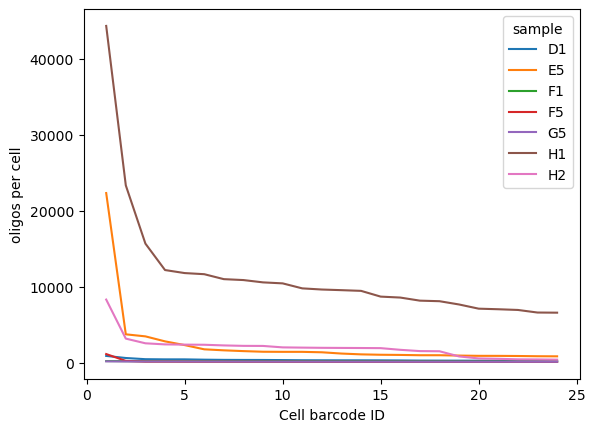

In [76]:
ax = sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['Cell barcode ID'] < 25],
    x='Cell barcode ID',
    y='oligos per cell',
    hue='sample'
)

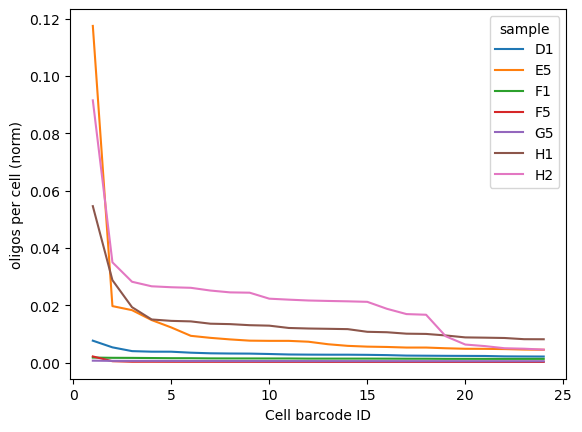

In [77]:
ax = sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['Cell barcode ID'] < 25],
    x='Cell barcode ID',
    y='oligos per cell (norm)',
    hue='sample'
)

# Old code

Since splitcode fails to assign any reads with that config file, try again with a modified config file dropping the `minFindsG` filter

In [153]:
path_config_nystgbot60_loose = os.path.join(DIR_AUX, 'splitcode_config-NYStgBot_60_loose.tsv')

In [154]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config_nystgbot60_loose}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

SAMPLE="F1"
path_R1="$(ls "$DIR_DATA"/*${SAMPLE}*R1_001.fastq.gz)"
path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
PATH_MAPPING="${DIR_AUX}/mapping-NYStgBot_60_loose-${SAMPLE}.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-NYStgBot_60_loose-${SAMPLE}.json"
PATH_OUTPUT="${DIR_AUX}/read_barcodes-NYStgBot_60_loose-${SAMPLE}.fasta.gz"
PATH_UNASSIGNED_R1="${DIR_AUX}/unassigned-NYStgBot_60_loose-${SAMPLE}.fasta.gz"

if [ ! -f "$PATH_OUTPUT" ] || true; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta --gzip -t 8 \
        --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
        --unassigned="$PATH_UNASSIGNED_R1" --output="$PATH_OUTPUT" \
        --select=0 "$path_R1" "$path_R2"
fi

* Using a list of 155 tags (vector size: 306; map size: 169,817; num elements in map: 200,558)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231002/BTY_scBarcode_F1_S4_L001_R1_001.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20231002/BTY_scBarcode_F1_S4_L001_R2_001.fastq.gz
* processing the reads ...
done 
* processed 222,593 reads, 222,272 reads were assigned


In [161]:
pd.read_csv(
    os.path.join(DIR_AUX, 'mapping-NYStgBot_60_loose-F1.tsv'),
    sep='\t',
    usecols=(1, 2),
    names=['barcode', 'count']
).pipe(lambda df: df.loc[df['barcode'].str.contains('NYLigOddStgTop_60')])

,barcode,count


In [162]:
df_data

,filename,sample,read,n_reads,complexity_tapestation,n_assigned
0,BTY_scBarcode_D1_S3_L001_R1_001.fastq.gz,D1,1,165855,129792,140775
1,BTY_scBarcode_D1_S3_L001_R2_001.fastq.gz,D1,2,165855,129792,140775
2,BTY_scBarcode_E5_S7_L001_R1_001.fastq.gz,E5,1,283029,217086,245930
3,BTY_scBarcode_E5_S7_L001_R2_001.fastq.gz,E5,2,283029,217086,245930
4,BTY_scBarcode_F1_S4_L001_R1_001.fastq.gz,F1,1,222593,178034,151949
5,BTY_scBarcode_F1_S4_L001_R2_001.fastq.gz,F1,2,222593,178034,151949
6,BTY_scBarcode_F5_S8_L001_R1_001.fastq.gz,F5,1,855403,556499,708574
7,BTY_scBarcode_F5_S8_L001_R2_001.fastq.gz,F5,2,855403,556499,708574
8,BTY_scBarcode_G5_S9_L001_R1_001.fastq.gz,G5,1,433572,339413,369613
9,BTY_scBarcode_G5_S9_L001_R2_001.fastq.gz,G5,2,433572,339413,369613


In [157]:
df_nystgbot60 = pd.read_csv(
    os.path.join(DIR_AUX, 'mapping-NYStgBot_60_loose-F1.tsv'),
    sep='\t',
    usecols=(1, 2),
    names=['barcode', 'count']
).pipe(lambda df: df.loc[df['barcode'].str.contains('NYStgBot_60')])

In [158]:
df_nystgbot60['count'].sum()

1157

In [160]:
with pd.option_context('display.max_rows', 1000, 'display.max_colwidth', 1000):
    display(df_nystgbot60)

,barcode,count
71,"OligoRC_bc3,adapter,NYStgBot_60,adapter",48
974,"OligoRC_bc5,NYStgBot_60",16
1105,"adapter,NYStgBot_60",43
1252,"OligoRC_bc5,adapter,NYStgBot_60,adapter",24
1398,"OligoRC_bc3,adapter,NYStgBot_60,Oligo_bc3",113
1670,"OligoRC_bc2,adapter,NYStgBot_60,Oligo_bc2",198
1776,"OligoRC_bc5,R1Top_22,NYStgBot_60",1
1902,"adapter,NYStgBot_60,adapter",19
2073,"OligoRC_bc3,NYStgBot_60",11
2351,"OligoRC_bc5,adapter,NYStgBot_60",12
